In [ ]:
from google.colab import drive
drive.mount('./content',force_remount=True)

Mounted at ./content


In [ ]:
import os
os.chdir('content/MyDrive/CIS680/MaskRCNN')

In [ ]:
from torchvision.models.detection.image_list import ImageList
import time

from utils import *
from pretrained_models import pretrained_models_680

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import os
from dataset import BuildDataset, BuildDataLoader
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from BoxHead import BoxHead
from MaskHead import MaskHead


In [ ]:
from torchvision import transforms

## test

In [ ]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, bboxes_path, labels_path]
epoch = 20
batch_size = 1
tolerance = 5
keep_topK = 100
torch.manual_seed(17)
os.makedirs('./mask_result', exist_ok=True)
save_dir = './mask_result'
dataset = BuildDataset(paths)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# rpn.to(device)
rpn = RPNHead(device=device)
rpn.load_state_dict(torch.load("./train_result/rpn_best_model.pth"))
rpn.eval()
test_build_loader = BuildDataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = test_build_loader.loader()

In [ ]:
box_head = BoxHead(Classes=3, P=7, device=device)
boxmodel_path = './best_model.pth'
box_pretrained = torch.load(boxmodel_path, map_location=lambda storage, loc: storage)
box_head.load_state_dict(box_pretrained)
box_head.eval()
box_head.to(device)

mask_head = MaskHead(P=14, device=device)
mask_head.to(device)
model = mask_head
mask_head_state = torch.load('./mask_result/best_model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(mask_head_state)
model.eval()

box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed
box_exceed


RuntimeError: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


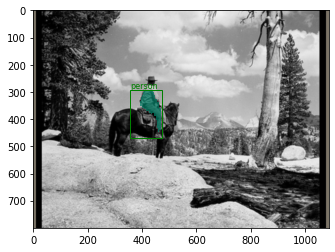

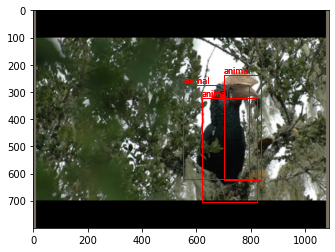

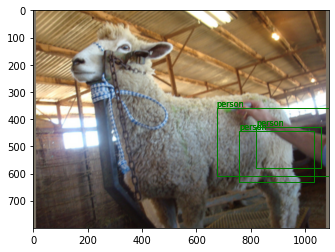

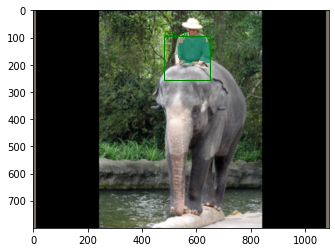

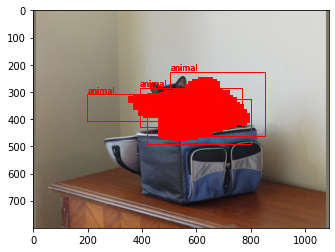

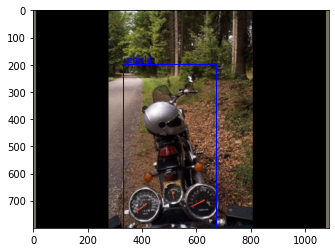

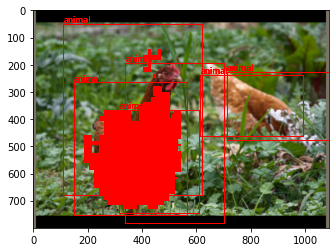

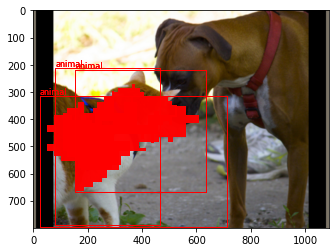

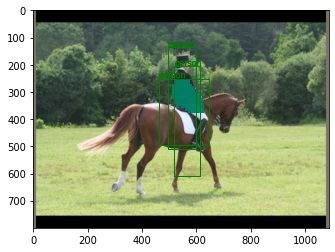

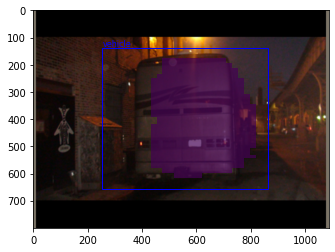

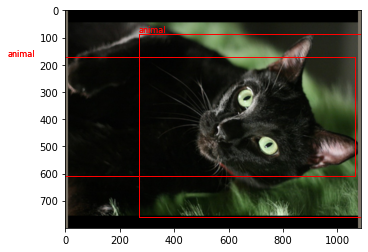

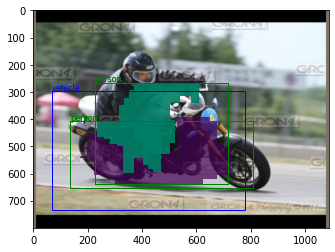

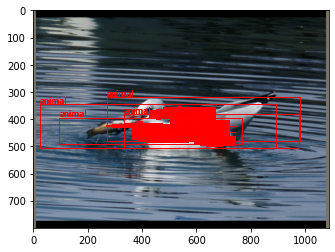

In [ ]:
for i, data_batch in enumerate(test_loader):
  images = data_batch['img'].to(device)
  bbox = data_batch["bbox"]
  labels = data_batch["labels"]
  masks = data_batch['masks']
  bbox = [b.to(device) for b in bbox]
  labels = [l.to(device) for l in labels]
  masks = [m.to(device) for m in masks]

  _, new_coord_list, X = rpn.forward_test(images)
  proposals=[proposal[0:keep_topK,:].detach() for proposal in new_coord_list]

  fpn_feat_list= [t.detach() for t in list(X.values())]
  #print(len(proposals))
  #print(proposals[0].shape)
  # b = time.time()
  feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list, proposals, P=box_head.P)
  class_logits, box_pred = box_head(feature_vectors)
  new_proposals = box_head.renew_proposals(proposals, box_pred, class_logits)
  #print(f'feature_vectors.shape{feature_vectors.shape}')
  feature_vector_mask = box_head.MultiScaleRoiAlign_mask(fpn_feat_list, new_proposals, P=mask_head.P)

  mask_pred = model(feature_vector_mask)
  boxes, scores, nms_labels, projected_masks = model.postprocess_mask(mask_pred, new_proposals, box_pred, class_logits)
  model.visualize_mask(images, boxes, nms_labels, projected_masks)
  
  if i > 100:
    break